In [100]:
import csv
import requests
from bs4 import BeautifulSoup
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tarfile
from scipy import stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedShuffleSplit, train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from urllib import request
from zlib import crc32

In [2]:
url="https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=y&type=8&season="

In [3]:
filename = "battingstats.csv"
f = open(filename, "w", encoding="utf8", newline="")
writer = csv.writer(f)

title = "#	Name	Team	G	PA	HR	R	RBI	SB	BB%	K%	ISO	BABIP	AVG	OBP	SLG	wOBA	xwOBA	wRC+	BsR	Off	Def	WAR".split("\t")
print(type(title))
writer.writerow(title)

for year in range(2010,2020):
    for page in range(1,4):
        res = requests.get(url + str(year) +"&month=0&season1=" + str(year) + "&ind=0&team=0&rost=0&age=0&filter=&players=0&page=" + str(page) + "_50")
        res.raise_for_status()
        soup = BeautifulSoup(res.text, "lxml")
        
        data_rows = soup.find("table", attrs={"class":"rgMasterTable"}).find("tbody").find_all("tr")
        for row in data_rows:
            columns = row.find_all("td")
            data = [column.get_text().strip() for column in columns]
            #print(data)
            writer.writerow(data)

<class 'list'>


In [4]:
stat = pd.read_csv('battingstats.csv')
stat

,#,Name,Team,G,PA,HR,R,RBI,SB,BB%,...,AVG,OBP,SLG,wOBA,xwOBA,wRC+,BsR,Off,Def,WAR
0,1,Josh Hamilton,TEX,133,571,32,95,100,8,7.5%,...,0.359,0.411,0.633,0.445,NaN,175,4.9,55.3,5.9,8.4
1,2,Carl Crawford,TBR,154,663,19,110,90,47,6.9%,...,0.307,0.356,0.495,0.369,NaN,135,13.3,40.2,11.1,7.7
2,3,Evan Longoria,TBR,151,661,22,96,104,15,10.9%,...,0.294,0.372,0.507,0.376,NaN,139,4.5,35.0,14.4,7.5
3,4,Joey Votto,CIN,150,648,37,106,113,16,14.0%,...,0.324,0.424,0.600,0.438,NaN,172,1.1,57.0,-10.1,6.9
4,5,Albert Pujols,STL,159,700,42,115,118,14,14.7%,...,0.312,0.414,0.596,0.419,NaN,164,0.9,54.2,-10.0,6.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1371,78,Jean Segura,PHI,144,618,12,79,60,10,4.9%,...,0.280,0.323,0.420,0.315,0.304,92,5.7,-0.5,5.0,2.4
1372,79,Kevin Newman,PIT,130,531,12,61,64,16,5.3%,...,0.308,0.353,0.446,0.339,0.297,109,-0.2,6.4,0.5,2.3
1373,80,Nick Ahmed,ARI,158,625,19,79,82,8,8.3%,...,0.254,0.316,0.437,0.315,0.320,91,2.2,-5.3,9.0,2.3
1374,81,Rhys Hoskins,PHI,160,705,29,86,85,2,16.5%,...,0.226,0.364,0.454,0.347,0.338,113,-2.7,9.6,-9.8,2.2


In [5]:
stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1376 entries, 0 to 1375
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   #       1376 non-null   int64  
 1   Name    1376 non-null   object 
 2   Team    1376 non-null   object 
 3   G       1376 non-null   int64  
 4   PA      1376 non-null   int64  
 5   HR      1376 non-null   int64  
 6   R       1376 non-null   int64  
 7   RBI     1376 non-null   int64  
 8   SB      1376 non-null   int64  
 9   BB%     1376 non-null   object 
 10  K%      1376 non-null   object 
 11  ISO     1376 non-null   float64
 12  BABIP   1376 non-null   float64
 13  AVG     1376 non-null   float64
 14  OBP     1376 non-null   float64
 15  SLG     1376 non-null   float64
 16  wOBA    1376 non-null   float64
 17  xwOBA   653 non-null    float64
 18  wRC+    1376 non-null   int64  
 19  BsR     1376 non-null   float64
 20  Off     1376 non-null   float64
 21  Def     1376 non-null   float64
 22  

In [6]:
stat["WAR"].value_counts()

2.5     38
2.4     35
2.9     34
2.7     34
2.2     33
        ..
9.7      1
10.2     1
8.2      1
9.5      1
7.5      1
Name: WAR, Length: 114, dtype: int64

In [7]:
stat.describe()

,#,G,PA,HR,R,RBI,SB,ISO,BABIP,AVG,OBP,SLG,wOBA,xwOBA,wRC+,BsR,Off,Def,WAR
count,1376.000000,1376.000000,1376.000000,1376.000000,1376.000000,1376.000000,1376.000000,1376.000000,1376.000000,1376.000000,1376.000000,1376.000000,1376.000000,653.000000,1376.000000,1376.000000,1376.000000,1376.000000,1376.000000
mean,70.575581,146.341570,608.279070,19.930233,76.967297,73.814680,10.319041,0.175367,0.306424,0.271511,0.339544,0.446873,0.339166,0.329276,112.277616,0.263590,9.672602,-1.006686,2.942515
std,41.377430,10.779626,61.176245,10.150980,17.498208,21.164735,11.057830,0.055993,0.032103,0.027221,0.033133,0.065334,0.034360,0.037424,22.995714,4.039138,17.415724,10.637574,2.079556
min,1.000000,113.000000,501.000000,0.000000,30.000000,17.000000,0.000000,0.036000,0.196000,0.168000,0.243000,0.268000,0.239000,0.240000,46.000000,-12.600000,-35.500000,-35.300000,-3.100000
25%,35.000000,139.000000,555.000000,12.000000,65.000000,58.000000,2.000000,0.134000,0.285000,0.253000,0.317000,0.400000,0.315000,0.302000,96.000000,-2.300000,-2.400000,-8.600000,1.500000
50%,69.000000,148.000000,609.000000,19.000000,76.000000,73.000000,6.000000,0.173000,0.306000,0.271000,0.337000,0.443000,0.337000,0.327000,111.000000,0.300000,8.300000,-1.450000,2.800000
75%,106.000000,155.250000,658.250000,27.000000,88.000000,88.000000,15.000000,0.216000,0.328000,0.290000,0.360000,0.491000,0.361000,0.353000,127.000000,2.900000,20.700000,5.725000,4.200000
max,149.000000,162.000000,754.000000,59.000000,137.000000,139.000000,68.000000,0.357000,0.406000,0.359000,0.460000,0.671000,0.461000,0.451000,197.000000,14.300000,77.700000,48.300000,10.400000


In [8]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [9]:
train_set, test_set = split_train_test(stat, 0.2)
len(test_set) / (len(train_set) + len(test_set))

0.1998546511627907

In [10]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

In [11]:
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [12]:
stat_with_id = stat.reset_index()

In [13]:
train_set, test_set = split_train_test_by_id(stat_with_id, 0.2, "index")
len(test_set) / (len(train_set) + len(test_set))

0.19912790697674418

In [14]:
train_set, test_set = train_test_split(stat, test_size=0.2, random_state=42)
len(test_set) / (len(train_set) + len(test_set))

0.2005813953488372

<AxesSubplot:>

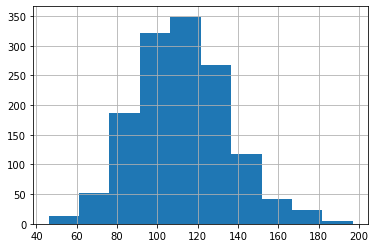

In [15]:
stat["wRC+"].hist()

In [16]:
stat["wRC+_cat"] = pd.cut(stat["wRC+"],
                          bins = [0, 80, 100, 120, 140, np.inf],
                          labels = [1, 2, 3, 4, 5])

In [17]:
stat["wRC+_cat"].value_counts()

3    471
4    333
2    326
5    139
1    107
Name: wRC+_cat, dtype: int64

<AxesSubplot:>

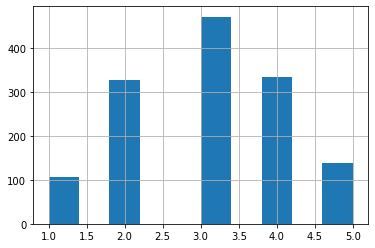

In [18]:
stat["wRC+_cat"].hist()

In [19]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=50)
for train_index, test_index in split.split(stat, stat["wRC+_cat"]):
    train_set = stat.loc[train_index]
    test_set = stat.loc[test_index]

In [20]:
len(test_set) / (len(train_set) + len(test_set))

0.2005813953488372

In [21]:
train_set["wRC+_cat"].value_counts() / len(train_set)

3    0.341818
4    0.241818
2    0.237273
5    0.100909
1    0.078182
Name: wRC+_cat, dtype: float64

In [22]:
test_set["wRC+_cat"].value_counts() / len(test_set)

3    0.344203
4    0.242754
2    0.235507
5    0.101449
1    0.076087
Name: wRC+_cat, dtype: float64

In [23]:
for set_ in (train_set, test_set):
    set_.drop("wRC+_cat", axis=1, inplace=True)

In [24]:
X_test = test_set.drop("WAR", axis=1) # drop labels for training set
y_test = test_set["WAR"].copy()

In [25]:
X_test = X_test.drop("Name", axis=1)
X_test = X_test.drop("Team", axis=1)
X_test = X_test.drop("BB%", axis=1)
X_test = X_test.drop("K%", axis=1)

In [26]:
corr_matrix = stat.corr()

In [27]:
corr_matrix["WAR"].sort_values(ascending=False)

WAR      1.000000
Off      0.842420
wRC+     0.773391
wOBA     0.762155
OBP      0.717540
R        0.691671
SLG      0.663603
xwOBA    0.600415
AVG      0.596545
ISO      0.484323
RBI      0.452780
BABIP    0.446634
HR       0.428924
Def      0.426637
PA       0.413795
BsR      0.315019
SB       0.222604
G        0.216818
#       -0.963613
Name: WAR, dtype: float64

array([[<AxesSubplot:xlabel='WAR', ylabel='WAR'>,
        <AxesSubplot:xlabel='Off', ylabel='WAR'>,
        <AxesSubplot:xlabel='wRC+', ylabel='WAR'>,
        <AxesSubplot:xlabel='wOBA', ylabel='WAR'>],
       [<AxesSubplot:xlabel='WAR', ylabel='Off'>,
        <AxesSubplot:xlabel='Off', ylabel='Off'>,
        <AxesSubplot:xlabel='wRC+', ylabel='Off'>,
        <AxesSubplot:xlabel='wOBA', ylabel='Off'>],
       [<AxesSubplot:xlabel='WAR', ylabel='wRC+'>,
        <AxesSubplot:xlabel='Off', ylabel='wRC+'>,
        <AxesSubplot:xlabel='wRC+', ylabel='wRC+'>,
        <AxesSubplot:xlabel='wOBA', ylabel='wRC+'>],
       [<AxesSubplot:xlabel='WAR', ylabel='wOBA'>,
        <AxesSubplot:xlabel='Off', ylabel='wOBA'>,
        <AxesSubplot:xlabel='wRC+', ylabel='wOBA'>,
        <AxesSubplot:xlabel='wOBA', ylabel='wOBA'>]], dtype=object)

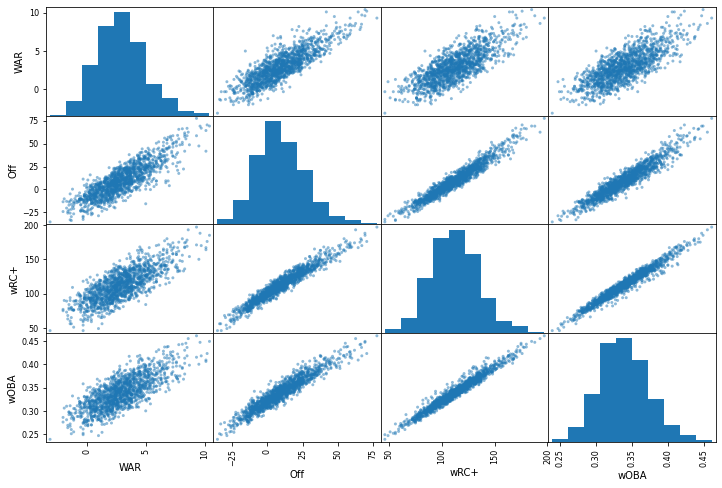

In [28]:
attributes = ["WAR", "Off", "wRC+", "wOBA"]
pd.plotting.scatter_matrix(stat[attributes], figsize=(12,8))

(0.0, 200.0, 0.0, 10.0)

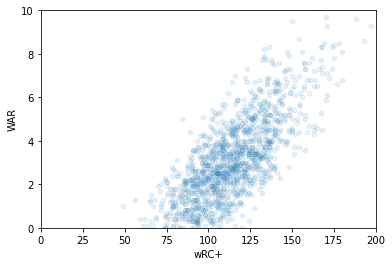

In [29]:
stat.plot(kind="scatter", x="wRC+", y="WAR", alpha=0.1)
plt.axis([0, 200, 0, 10])

In [30]:
stat = train_set.drop("WAR", axis=1) 
stat_labels = train_set["WAR"].copy()

In [31]:
stat_num = stat.drop("Name", axis=1)
stat_num = stat_num.drop("Team", axis=1)
stat_num = stat_num.drop("BB%", axis=1)
stat_num = stat_num.drop("K%", axis=1)

In [32]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

In [33]:
stat_num.head()

,#,G,PA,HR,R,RBI,SB,ISO,BABIP,AVG,OBP,SLG,wOBA,xwOBA,wRC+,BsR,Off,Def
352,59,151,615,32,68,108,6,0.237,0.303,0.262,0.322,0.499,0.350,NaN,117,-3.1,9.6,2.2
137,138,154,649,22,63,76,0,0.167,0.270,0.248,0.312,0.415,0.318,NaN,93,-4.8,-10.2,-14.0
399,106,147,561,8,67,45,26,0.107,0.293,0.243,0.306,0.349,0.290,NaN,87,6.1,-2.8,3.4
1301,8,155,698,33,110,117,4,0.246,0.338,0.309,0.384,0.555,0.390,0.349,141,1.0,37.7,8.1
332,39,144,567,20,70,79,3,0.174,0.352,0.293,0.372,0.467,0.365,NaN,132,-6.4,14.9,3.7


In [34]:
imputer = SimpleImputer(strategy="median")

In [35]:
imputer.fit(stat_num)

SimpleImputer(strategy='median')

In [36]:
imputer.strategy

'median'

In [37]:
imputer.statistics_

array([ 6.90e+01,  1.48e+02,  6.10e+02,  2.00e+01,  7.60e+01,  7.40e+01,
        7.00e+00,  1.74e-01,  3.06e-01,  2.71e-01,  3.37e-01,  4.45e-01,
        3.37e-01,  3.29e-01,  1.11e+02,  3.00e-01,  8.35e+00, -1.40e+00])

In [38]:
stat_num.median().values

array([ 6.90e+01,  1.48e+02,  6.10e+02,  2.00e+01,  7.60e+01,  7.40e+01,
        7.00e+00,  1.74e-01,  3.06e-01,  2.71e-01,  3.37e-01,  4.45e-01,
        3.37e-01,  3.29e-01,  1.11e+02,  3.00e-01,  8.35e+00, -1.40e+00])

In [39]:
X = imputer.transform(stat_num)

In [40]:
stat_tr = pd.DataFrame(X, columns = stat_num.columns, index=stat.index)

In [44]:
stat_num_tr = num_pipeline.fit_transform(stat_num)
stat_num_tr

array([[-0.26924189,  0.42818094,  0.11028324, ..., -0.85363271,
        -0.01028497,  0.28506869],
       [ 1.63420102,  0.7102726 ,  0.67290678, ..., -1.27297049,
        -1.14334825, -1.22555462],
       [ 0.86318617,  0.05205873, -0.78329532, ...,  1.41572474,
        -0.71988016,  0.39696671],
       ...,
       [-1.3052931 , -0.13600237,  0.2261175 , ..., -0.80429885,
         1.90676654, -1.28150363],
       [-1.57032945,  1.46251701,  2.2945864 , ...,  0.33037987,
         1.626362  ,  1.39472408],
       [ 0.23673661, -1.17033844, -0.75019982, ..., -1.54430671,
         0.327345  , -0.77796253]])

In [45]:
stat_num_tr.shape

(1100, 18)

In [46]:
lin_reg = LinearRegression()
lin_reg.fit(stat_num_tr, stat_labels)

LinearRegression()

In [47]:
stat = stat.drop("Name", axis=1)
stat = stat.drop("Team", axis=1)
stat = stat.drop("BB%", axis=1)
stat = stat.drop("K%", axis=1)

In [48]:
some_data = stat.iloc[:5]
some_data_prepared = num_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 3.31528559 -0.29100273  1.94108739  6.94176619  3.89805991]


In [49]:
stat_predictions = lin_reg.predict(stat_num_tr)
lin_mse = mean_squared_error(stat_labels, stat_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.10781686784085856

In [50]:
lin_mae = mean_absolute_error(stat_labels, stat_predictions)
lin_mae

0.08903781997363665

In [51]:
from sklearn.tree import DecisionTreeRegressor

In [52]:
tree_reg = DecisionTreeRegressor(random_state=50)
tree_reg.fit(stat_num_tr, stat_labels)

DecisionTreeRegressor(random_state=50)

In [53]:
some_data = stat.iloc[:5]
some_data_prepared = num_pipeline.transform(some_data)
print("Predictions:", tree_reg.predict(some_data_prepared))

Predictions: [ 3.2 -0.1  1.8  6.8  3.7]


In [54]:
some_labels = stat_labels.iloc[:5]
print("Labels:", list(some_labels))

Labels: [3.2, -0.1, 1.8, 6.8, 3.7]


In [55]:
stat_predictions = tree_reg.predict(stat_num_tr)
tree_reg_mse = mean_squared_error(stat_labels, stat_predictions)
tree_reg_rmse = np.sqrt(tree_reg_mse)
tree_reg_rmse

7.901923793763022e-17

In [56]:
tree_reg_mae = mean_absolute_error(stat_labels, stat_predictions)
tree_reg_mae

1.3940868661486342e-17

In [57]:
lin_reg = LinearRegression()
lin_scores = cross_val_score(lin_reg, stat_num_tr, stat_labels,
                                scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-lin_scores)).describe()

count    10.000000
mean      0.109727
std       0.008418
min       0.099113
25%       0.103977
50%       0.108382
75%       0.113750
max       0.126855
dtype: float64

In [58]:
tree_reg = DecisionTreeRegressor(random_state=50)
tree_scores = cross_val_score(tree_reg, stat_num_tr, stat_labels,
                                scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-tree_scores)).describe()

count    10.000000
mean      0.370523
std       0.054531
min       0.276340
25%       0.330066
50%       0.383700
75%       0.415901
max       0.434950
dtype: float64

In [59]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=50)
forest_scores = cross_val_score(forest_reg, stat_num_tr, stat_labels,
                                scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-forest_scores)).describe()

count    10.000000
mean      0.272539
std       0.041084
min       0.218372
25%       0.239583
50%       0.267313
75%       0.309975
max       0.326325
dtype: float64

In [60]:
svm_reg = SVR(kernel="linear")
svm_scores = cross_val_score(svm_reg, stat_num_tr, stat_labels,
                                scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-svm_scores)).describe()

count    10.000000
mean      0.110066
std       0.008139
min       0.101140
25%       0.104881
50%       0.108279
75%       0.114057
max       0.126935
dtype: float64

In [61]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

In [76]:
forest_reg = RandomForestRegressor(random_state=50)

In [103]:
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(stat_num_tr, stat_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=50),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [104]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [106]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=50)

In [107]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.027132,0.026675,0.003123,0.002855,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-0.564359,-0.662035,...,-0.642198,0.069601,18,-1.650328e-01,-2.068510e-01,-1.563258e-01,-2.074078e-01,-1.749318e-01,-1.821098e-01,2.126067e-02
1,0.044204,0.010854,0.003904,0.002139,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-0.423802,-0.284265,...,-0.388748,0.073848,16,-9.793352e-02,-7.293682e-02,-6.579352e-02,-7.298739e-02,-8.046227e-02,-7.802270e-02,1.098331e-02
2,0.177119,0.109362,0.010931,0.008804,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-0.313579,-0.209272,...,-0.304465,0.074485,13,-5.515314e-02,-4.307431e-02,-4.860566e-02,-4.873636e-02,-5.350346e-02,-4.981459e-02,4.246491e-03
3,0.027040,0.004579,0.003031,0.000992,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-0.199955,-0.226455,...,-0.280530,0.079796,12,-7.914646e-02,-7.806061e-02,-7.120328e-02,-8.913131e-02,-8.254419e-02,-8.001717e-02,5.860449e-03
4,0.048520,0.009206,0.002734,0.001294,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-0.176780,-0.127520,...,-0.170590,0.040792,8,-4.120977e-02,-3.704511e-02,-2.740386e-02,-3.363148e-02,-3.317011e-02,-3.449207e-02,4.568948e-03
5,0.136945,0.039436,0.006050,0.001680,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-0.141252,-0.103447,...,-0.128588,0.026858,5,-2.506447e-02,-2.223582e-02,-1.925896e-02,-2.037386e-02,-1.974973e-02,-2.133657e-02,2.119773e-03
6,0.051405,0.042828,0.004487,0.003982,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-0.173495,-0.200576,...,-0.177183,0.022118,9,-6.568434e-02,-5.891540e-02,-4.999621e-02,-5.777904e-02,-5.140909e-02,-5.675682e-02,5.651710e-03
7,0.046083,0.014625,0.002129,0.000401,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-0.089385,-0.093965,...,-0.105689,0.023465,4,-2.608636e-02,-2.288261e-02,-1.978523e-02,-2.226807e-02,-2.406625e-02,-2.301770e-02,2.075824e-03
8,0.178340,0.048992,0.014629,0.018069,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-0.073255,-0.077285,...,-0.093528,0.025750,2,-1.536169e-02,-1.521563e-02,-1.495711e-02,-1.582792e-02,-1.542475e-02,-1.535742e-02,2.850514e-04
9,0.022940,0.005542,0.001171,0.000390,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-0.171328,-0.163091,...,-0.148318,0.023748,7,-5.677652e-02,-5.959722e-02,-4.021086e-02,-5.153788e-02,-4.119949e-02,-4.986439e-02,7.919307e-03


In [108]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.62513817, 0.00150827, 0.00173967, 0.00105612, 0.02221773,
       0.00125766, 0.0015986 , 0.00101471, 0.00187988, 0.00220194,
       0.00916789, 0.0013467 , 0.06271487, 0.00139872, 0.05234423,
       0.00298568, 0.16978505, 0.04064412])

In [109]:
final_model = grid_search.best_estimator_

In [110]:
num_pipeline_with_predictor = Pipeline([
        ("preparation", num_pipeline),
        ("final model", final_model)
    ])

In [111]:
joblib.dump(num_pipeline_with_predictor, "my_model.pkl") # DIFF
my_model_loaded = joblib.load("my_model.pkl") # DIFF

In [112]:
y_test_pred = my_model_loaded.predict(X_test)

In [113]:
final_mse = mean_squared_error(y_test, y_test_pred)
final_rmse = np.sqrt(final_mse)
final_rmse

0.22177016217453116